<a href="https://colab.research.google.com/github/ziatdinovmax/pyroVED/blob/main/examples/rVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rotationally-invariant VAE: Application to arbitrary rotated 2D images


---

This notebook demonstrates how to apply a rotationally-invariant variational autoencoder (VAE) to the arbitrary rotated images of handwritten digits.

---



Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

In [9]:
#@title Installation
!pip install -q pyroved kornia

In [10]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

tt = torch.tensor

In [11]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.geometry.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [12]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

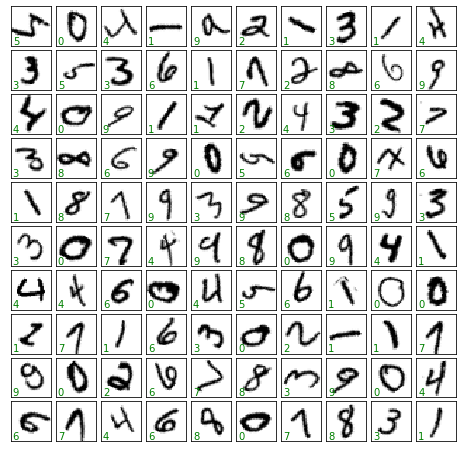

In [13]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.argmax().item()),
            transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [14]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 225.2608
Epoch: 2 Training loss: 192.4384
Epoch: 3 Training loss: 186.4442
Epoch: 4 Training loss: 182.7192
Epoch: 5 Training loss: 180.4038
Epoch: 6 Training loss: 178.6122
Epoch: 7 Training loss: 177.1992
Epoch: 8 Training loss: 175.8587
Epoch: 9 Training loss: 174.7088
Epoch: 10 Training loss: 173.7610
Epoch: 11 Training loss: 172.8364
Epoch: 12 Training loss: 172.0301
Epoch: 13 Training loss: 171.3988
Epoch: 14 Training loss: 170.7647
Epoch: 15 Training loss: 170.3082
Epoch: 16 Training loss: 169.7950
Epoch: 17 Training loss: 169.4048
Epoch: 18 Training loss: 168.9818
Epoch: 19 Training loss: 168.6322
Epoch: 20 Training loss: 168.4274
Epoch: 21 Training loss: 168.1124
Epoch: 22 Training loss: 167.7474
Epoch: 23 Training loss: 167.5327
Epoch: 24 Training loss: 167.2328
Epoch: 25 Training loss: 167.0344
Epoch: 26 Training loss: 166.7924
Epoch: 27 Training loss: 166.5956
Epoch: 28 Training loss: 166.3705
Epoch: 29 Training loss: 166.2433
Epoch: 30 Training loss

Visualize the learned latent manifold:

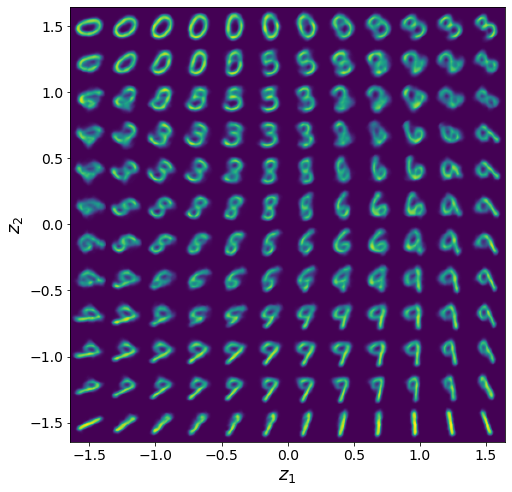

In [15]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

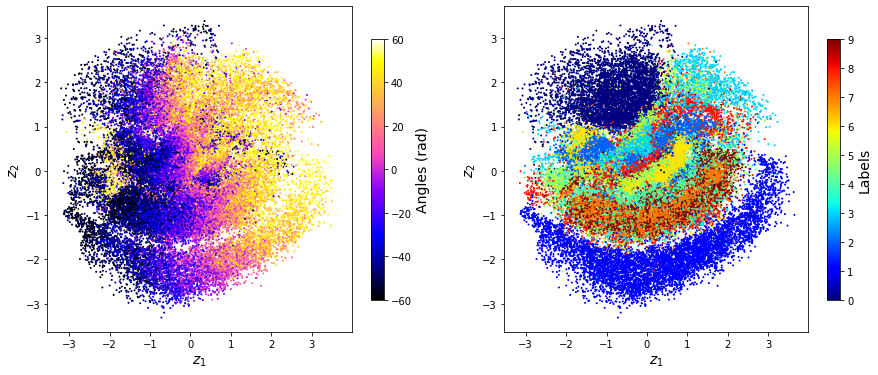

In [16]:
z_mean, z_sd = vae.encode(train_data)
_, labels = torch.max(train_labels, 1)
labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

The examination of latent space shows that the angle changes along the first latent direction, whereas the digit changes mostly along the second latent dimension. This clearly illustrates the disentanglement of the data representation concept, where the rotational angle and class emerge as the two most prominent factors of variation within the data.

Now let's train VAE with rotational invariance (aka rVAE):

In [17]:
# Reinitialize dataloader
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

In [18]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(rvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 251.5800
Epoch: 2 Training loss: 206.7223
Epoch: 3 Training loss: 197.0080
Epoch: 4 Training loss: 191.4121
Epoch: 5 Training loss: 187.0545
Epoch: 6 Training loss: 184.2969
Epoch: 7 Training loss: 182.3275
Epoch: 8 Training loss: 180.7379
Epoch: 9 Training loss: 179.4493
Epoch: 10 Training loss: 178.2529
Epoch: 11 Training loss: 177.7237
Epoch: 12 Training loss: 176.5494
Epoch: 13 Training loss: 176.0296
Epoch: 14 Training loss: 175.3076
Epoch: 15 Training loss: 175.0799
Epoch: 16 Training loss: 174.2435
Epoch: 17 Training loss: 173.8404
Epoch: 18 Training loss: 173.6487
Epoch: 19 Training loss: 173.1722
Epoch: 20 Training loss: 172.6439
Epoch: 21 Training loss: 172.2523
Epoch: 22 Training loss: 172.0611
Epoch: 23 Training loss: 171.8164
Epoch: 24 Training loss: 171.3706
Epoch: 25 Training loss: 171.0353
Epoch: 26 Training loss: 170.9686
Epoch: 27 Training loss: 170.5740
Epoch: 28 Training loss: 170.5630
Epoch: 29 Training loss: 170.1028
Epoch: 30 Training loss

Visualize the learned latent manifold:

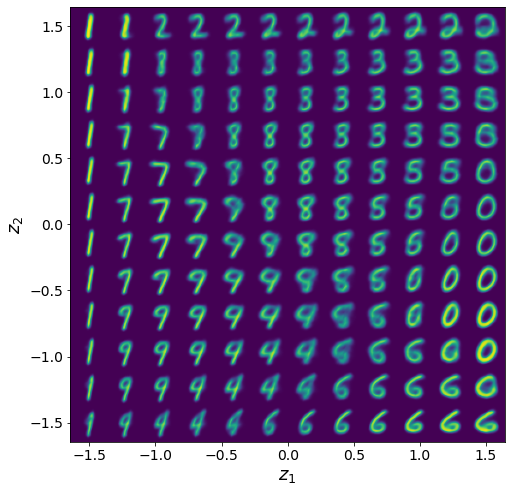

In [19]:
rvae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

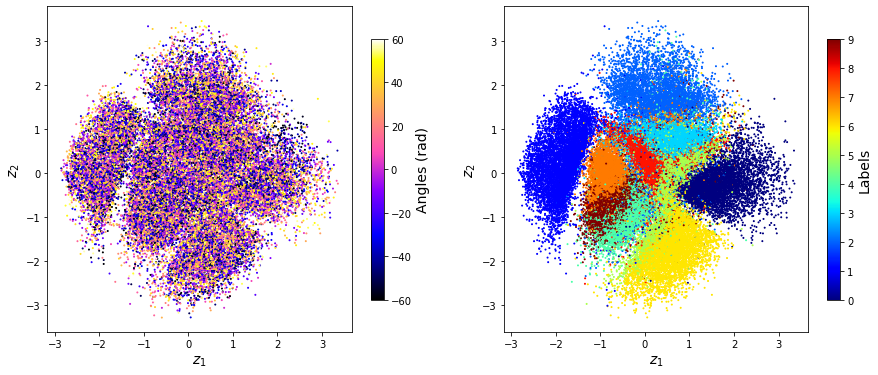

In [20]:
z_mean, z_sd = rvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In this case, the digits in the latent space are oriented in one direction. The latent space shows that the angles are now random, whereas the digits form well-defined clusters (rather remarkable given that we encode the data set using only two latent variables). We also get the angle as one of the latent variables, and the latent angle and ground truth angle are compared in the figure above. Note that they are linearly related, but at the same time latent angles have broad distribution. This is unsurprising since an angle is one of the characteristics of handwriting style and varies from person to person! The latent representation we discovered hence compensated by this fact via introducing it as an additional augmentation variable, and then separating it from other factors of variation.


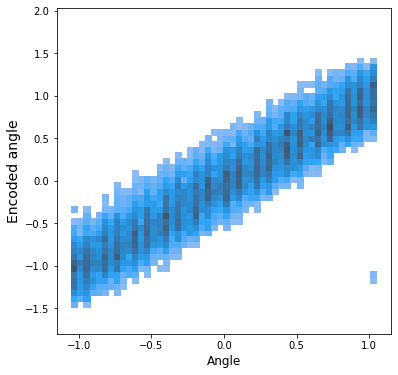

In [21]:
plt.figure(figsize=(6, 6))
plt.xlabel("Angle", fontsize=12)
plt.ylabel("Encoded angle", fontsize=14)
ax = sns.histplot(x=torch.deg2rad(angles.float()), y=z_mean[:, 0], bins=50, pthresh=.1);

Finally, we illustrate the class-conditioned rVAE (crVAE) applied to this data set. Note that the only two things we have to do is add labels to our data loader and specify number of classes (as ```c_dim```) when initializing the crVAE model - pyroVED will take care of the rest.

In [22]:
# Initialize dataloader (here we are adding labels to the training data)
train_loader = pv.utils.init_dataloader(train_data, train_labels, batch_size=200)

In [23]:
in_dim = (28, 28)

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
crvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim=10, invariances=['r'], seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(crvae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader, scale_factor=3)
    trainer.print_statistics()

Epoch: 1 Training loss: 242.1900
Epoch: 2 Training loss: 191.7969
Epoch: 3 Training loss: 179.7957
Epoch: 4 Training loss: 175.4523
Epoch: 5 Training loss: 172.1769
Epoch: 6 Training loss: 169.5616
Epoch: 7 Training loss: 165.9448
Epoch: 8 Training loss: 164.1108
Epoch: 9 Training loss: 162.9780
Epoch: 10 Training loss: 162.2704
Epoch: 11 Training loss: 161.4605
Epoch: 12 Training loss: 160.9877
Epoch: 13 Training loss: 160.5529
Epoch: 14 Training loss: 159.8983
Epoch: 15 Training loss: 159.6024
Epoch: 16 Training loss: 159.3124
Epoch: 17 Training loss: 159.1703
Epoch: 18 Training loss: 158.7765
Epoch: 19 Training loss: 158.4426
Epoch: 20 Training loss: 158.4152
Epoch: 21 Training loss: 158.0571
Epoch: 22 Training loss: 157.8324
Epoch: 23 Training loss: 157.7071
Epoch: 24 Training loss: 157.5461
Epoch: 25 Training loss: 157.3735
Epoch: 26 Training loss: 157.2619
Epoch: 27 Training loss: 157.0185
Epoch: 28 Training loss: 156.7959
Epoch: 29 Training loss: 156.6902
Epoch: 30 Training loss

View the learned latent manifold for each class:

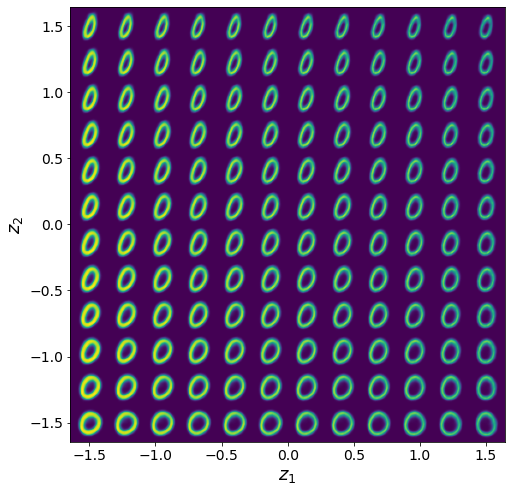

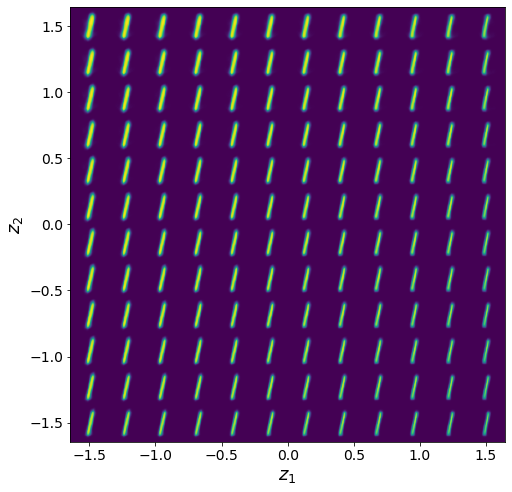

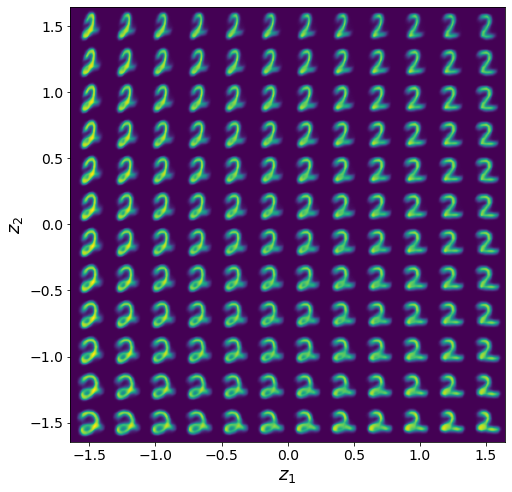

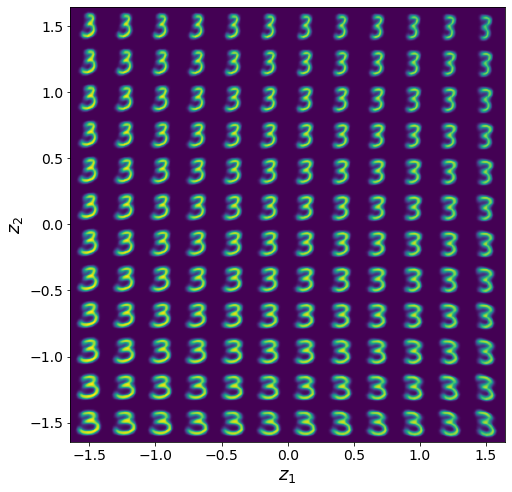

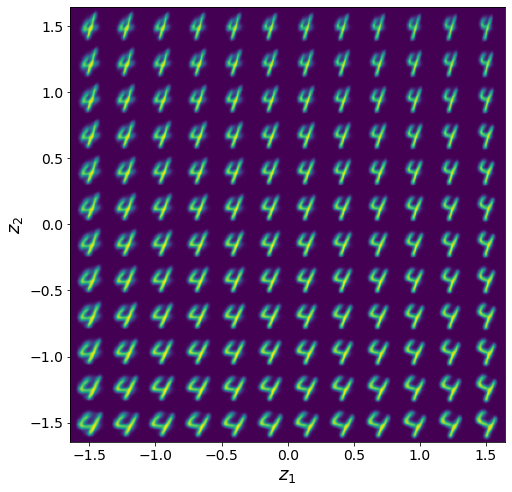

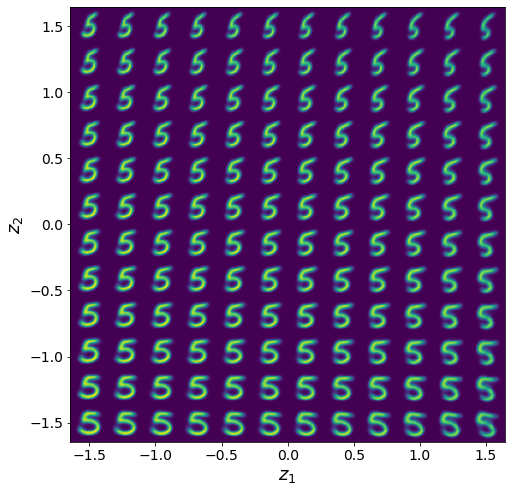

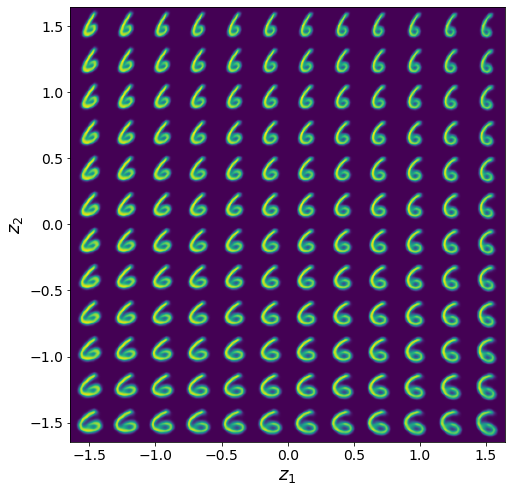

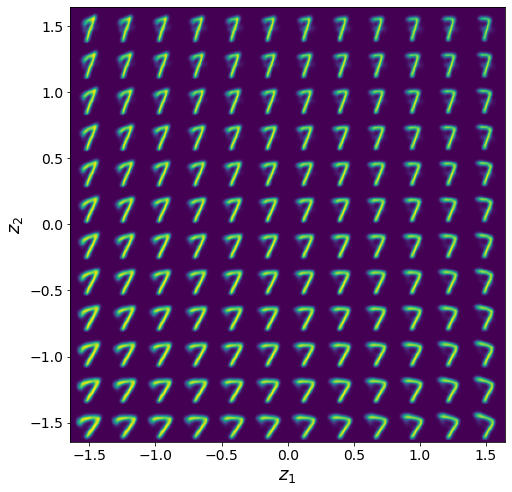

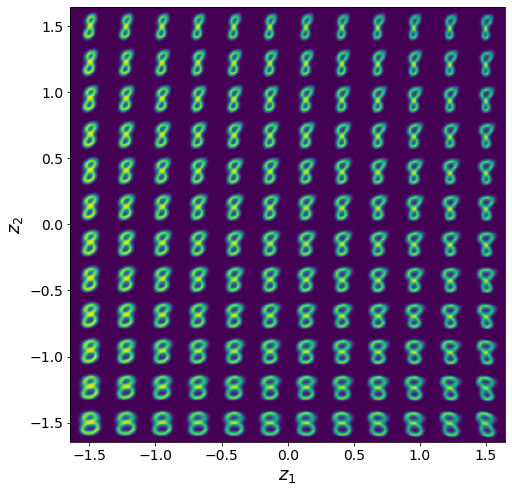

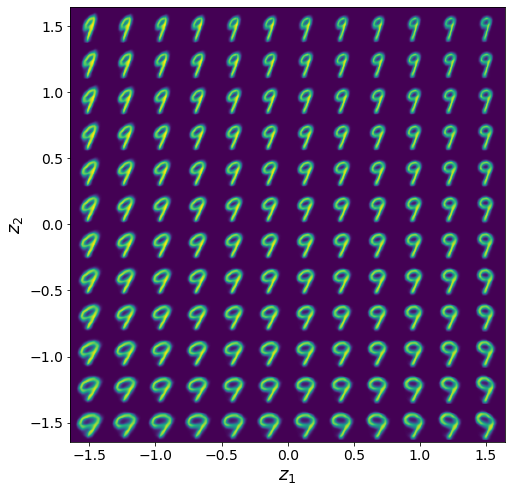

In [24]:
for cls in range(10):
    cls = pv.utils.to_onehot(tt([cls,]), 10)
    crvae.manifold2d(d=12, y=cls, cmap="viridis")

In this case, our latent reconstructions clearly show that within each latent space, the digits are oriented in the same direction, and latent variables now encode very subtle details of the handwriting styles.

Encode all the data and view the encoded values as a scatter plot:

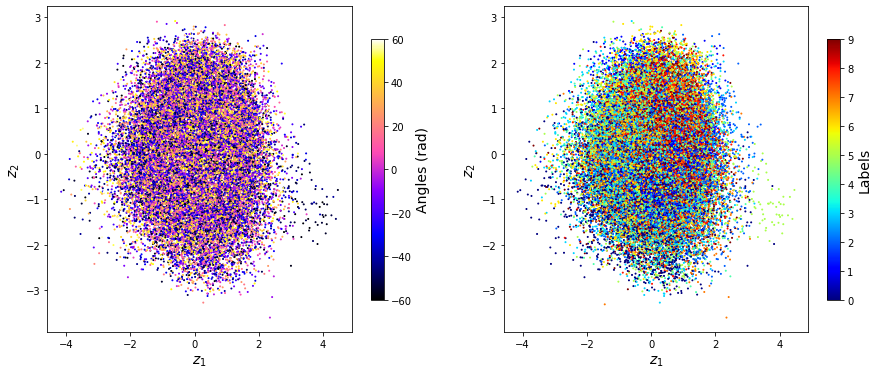

In [25]:
z_mean, z_sd = crvae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,2], z_mean[:,1], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,2], z_mean[:,1], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10)